In [155]:
import pandas as pd
import numpy as np
import os

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline

# Suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [131]:
def process_sensor_data(file_path, Hz = 50):
    # path = "/Users/alexanderithakis/Documents/GitHub/ML4QS/Python3Code/Data/Ezra/"

    Hz =50
    """
    This function processes sensor data from accelerometer, gyroscope, and linear accelerometer CSV files.

    Parameters:
    file_path (str): The path to the directory containing the CSV files. The directory should contain 'Accelerometer.csv', 'Gyroscope.csv', and 'Linear Accelerometer.csv'.

    Returns:
    df_interpolated (DataFrame): A DataFrame containing the interpolated sensor data. The DataFrame is indexed by time in seconds, and each column corresponds to a sensor reading.

    The function first reads the data from the CSV files and sets the time as the index. It then joins the data from the three files into a single DataFrame, sorting by time.
    The function then creates a new DataFrame to hold the interpolated data. It uses cubic spline interpolation to fill in any missing values in the sensor data.
    """

    accel = pd.read_csv(file_path+ "Accelerometer.csv").set_index("Time (s)")
    accel.columns = ["Accel X (m/s^2)", "Accel Y (m/s^2)", "Accel Z (m/s^2)"]
    gyro = pd.read_csv(file_path+ "Gyroscope.csv").set_index("Time (s)")
    gyro.columns = ["Gyro X (m/s^2)", "Gyro Y (m/s^2)", "Gyro Z (m/s^2)"]
    linear_accel = pd.read_csv(file_path+ "Linear Accelerometer.csv").set_index("Time (s)")
    linear_accel.columns = ["Lin Accel X (m/s^2)", "Lin Accel Y (m/s^2)", "Lin Accel Z (m/s^2)"]

    times = np.array(list(range(1, int(max(gyro.index.values)) * Hz))) / Hz

    df = accel.join(gyro, on="Time (s)", how="outer", rsuffix="_gyro").join(linear_accel, on="Time (s)", how="outer", rsuffix="_lin").set_index("Time (s)").sort_index()

    df_interpolated = pd.DataFrame(index=pd.Series(times, name="Time (s)"), columns=df.columns, data=np.zeros((times.shape[0], df.shape[1]))*np.nan)

    for col in df.columns:
        _values = df[col].values
        idx = np.isnan(_values)
        cs = CubicSpline(df.index.values[~idx], _values[~idx])
        df_interpolated[col] = cs(times)

    maxTime = 42 * 60 * Hz
    postureInterval = 2 * 60 * Hz
    transTime = 10  

    end_of_experiment_time = maxTime + transTime * Hz
    # Remove data after experiment is done
    df_interpolated = df_interpolated.iloc[df_interpolated.index.get_level_values(0) < (42*60 + 10)].sort_index()

    # Label order of experiment
    labelOrder          = ['L', 'R', 'L', 'F', 'L', 'B', 'L', 'S', 'R', 'F', 'R', 'B', 'R', 'S', 'F', 'B', 'F', 'S', 'B', 'S', 'L']
    labelOrderAlexander = ['L', 'R', 'L', 'F', 'L', 'B', 'L', 'S', 'R', 'F', 'B', 'B', 'R', 'S', 'F', 'B', 'F', 'S', 'B', 'S', 'L']

    # file_path
    if 'Alexander' in file_path: labelOrder = labelOrderAlexander
    # Set start times of transitions and labels, with 10 second time for transitions
    transPos = [i for i in range(0, len(df_interpolated), postureInterval)][:-1]
    labelPos = [time + transTime * Hz for time in transPos]

    transPos , len(df_interpolated)

    # Set labels
    labels = np.chararray(len(df_interpolated), unicode = True)
    for i, _times in enumerate(zip(transPos, labelPos)):
        # print(len(labels))
        labels[_times[0]:] = 'T'
        labels[_times[1]:] = labelOrder[i]
        
    df_interpolated["Label"] = labels

    return df_interpolated

In [132]:
# open the folder named Data and get the names of the files
path = "/Users/alexanderithakis/Documents/GitHub/ML4QS/Python3Code/Data/"
files = os.listdir(path)


dfs = []
for _file in files:
    if _file[0] == '.': continue
    _df = process_sensor_data(path + _file + '/')
    # add to the _df a row with the name of the file which is going to be added to the index, so the index will have 2 levels
    _df = _df.assign(Participant = _file)
    _df = _df.set_index('Participant', append=True)
    dfs.append(_df)
    # break

dfs = pd.concat(dfs)
dfs

Accel X (m/s^2)  Accel Y (m/s^2)  Accel Z (m/s^2)  \
Time (s) Participant                                                      
0.02     Ezra               -6.695648         6.425763         2.890562   
0.04     Ezra               -7.306077         6.184132         3.166081   
0.06     Ezra               -7.165934         6.242556         3.196803   
0.08     Ezra               -7.057753         6.326050         3.187511   
0.10     Ezra               -6.914651         6.259296         3.146490   
...                               ...              ...              ...   
2523.90  Sjors              -2.563917         9.418729         2.101827   
2523.92  Sjors              -2.239452         9.239055         2.222676   
2523.94  Sjors              -2.192481         9.256724         2.210018   
2523.96  Sjors              -2.325050         9.284401         2.213467   
2523.98  Sjors              -2.372463         9.256119         2.192386   

                      Gyro X (m/s^2)  Gyro Y (m/s^2)  Gyro Z (m/s^2)  \
Time (s) Participant                                                   
0.02     Ezra              -0.031204        0.219063       -0.027557   
0.04     Ezra              -0.004081        0.102260       -0.025153   
0.06     Ezra               0.002151        0.016317       -0.007400   
0.08     Ezra               0.018974       -0.003981        0.014050   
0.10     Ezra               0.025652        0.005295        0.024584   
...                              ...             ...             ...   
2523.90  Sjors              0.013782       -0.060343        0.017629   
2523.92  Sjors              0.012139       -0.075650       -0.037158   
2523.94  Sjors              0.011882       -0.050519       -0.067697   
2523.96  Sjors              0.009226       -0.024324       -0.071850   
2523.98  Sjors              0.005410       -0.031199       -0.070311   

                      Lin Accel X (m/s^2)  Lin Accel Y (m/s^2)  \
Time (s) Participant                                             
0.02     Ezra                    0.266295             0.195861   
0.04     Ezra                   -0.405272            -0.160486   
0.06     Ezra                   -0.393979            -0.133335   
0.08     Ezra                   -0.248121            -0.018309   
0.10     Ezra                   -0.127193            -0.097493   
...                                   ...                  ...   
2523.90  Sjors                  -0.332171             0.134921   
2523.92  Sjors                   0.014699            -0.027746   
2523.94  Sjors                   0.082193            -0.047331   
2523.96  Sjors                  -0.025103             0.009627   
2523.98  Sjors                  -0.055141            -0.034242   

                      Lin Accel Z (m/s^2) Label  
Time (s) Participant                             
0.02     Ezra                   -0.270117     T  
0.04     Ezra                    0.070983     T  
0.06     Ezra                    0.127672     T  
0.08     Ezra                    0.139324     T  
0.10     Ezra                    0.100887     T  
...                                   ...   ...  
2523.90  Sjors                  -0.077430     L  
2523.92  Sjors                   0.028434     L  
2523.94  Sjors                   0.027077     L  
2523.96  Sjors                   0.023703     L  
2523.98  Sjors                   0.018467     L  

[378947 rows x 10 columns]

In [156]:
_df_Ezra = dfs.query("Participant == 'Ezra' ")
_df_Ezra['Time (min)'] = _df_Ezra.index.get_level_values('Time (s)').values / 60

colors = np.zeros(len(_df_Ezra), dtype = "<U10")
colDict = {"T": "black", "R": "green", "L": "yellow", "B": "blue", "S": "red", "F": "turquoise"}

# Function to segment the data by continuous label
def segment_data(df):
    segments = []
    current_label = df.iloc[0]['Label']
    start_idx = 0
    for idx in range(1, len(df)):
        if df.iloc[idx]['Label'] != current_label:
            segments.append(df[start_idx:idx])
            start_idx = idx
            current_label = df.iloc[idx]['Label']
    segments.append(df[start_idx:])  # add the last segment
    return segments


segments = segment_data(_df_Ezra.reset_index())

# Create the plot
fig = go.Figure()

labelOrder = ['L', 'R', 'L', 'F', 'L', 'B', 'L', 'S', 'R', 'F', 'R', 'B', 'R', 'S', 'F', 'B', 'F', 'S', 'B', 'S', 'L']

# New order for labels
newLabOrder = []
for label in labelOrder:
    newLabOrder.append('T')
    newLabOrder.append(label)

# Add each segment as a separate trace
legend_added = set()
for i, segment in enumerate(segments):
    label = newLabOrder[i]
    show_legend = label not in legend_added
    fig.add_trace(go.Scatter(
        x = segment['Time (min)'],
        y = segment['Accel X (m/s^2)'],
        mode = 'lines',
        name = label,
        line = {
            "color": colDict[label]
        },
        showlegend = show_legend
    )),
    legend_added.add(label)

# Update layout
fig.update_layout(
    title = "Smartphone Accelerometer Time Series for Different Postures",
    xaxis_title = "Time (min)",
    yaxis_title = "Acceleration X (m/s^2)"
)
# update the size of the plot so it looks good on overleaf
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
)

Hz = 50
maxTime = 42
postureInterval = 2
transTime = 10/60

for i in range(0, maxTime + postureInterval, postureInterval):
    fig.add_vline(x = i + (transTime)  , line_dash="dash")

# Show the plot
fig.show()

---------------------
# **Feature Engineering**

[Pipeline] ... (step 1 of 5) Processing standard_scaler, total=   0.0s
[Pipeline] .... (step 2 of 5) Processing lowpass_filter, total=   0.0s
[Pipeline] ........ (step 3 of 5) Processing lof_marker, total=  42.8s
[Pipeline]  (step 4 of 5) Processing cubic_spline_interpolator, total=   0.1s
[Pipeline]  (step 5 of 5) Processing exponential_rolling_features, total=   0.0s
[Pipeline] ... (step 1 of 5) Processing standard_scaler, total=   0.0s
[Pipeline] .... (step 2 of 5) Processing lowpass_filter, total=   0.0s
[Pipeline] ........ (step 3 of 5) Processing lof_marker, total=  42.7s
[Pipeline]  (step 4 of 5) Processing cubic_spline_interpolator, total=   0.1s
[Pipeline]  (step 5 of 5) Processing exponential_rolling_features, total=   0.0s
[Pipeline] ... (step 1 of 5) Processing standard_scaler, total=   0.0s
[Pipeline] .... (step 2 of 5) Processing lowpass_filter, total=   0.0s
[Pipeline] ........ (step 3 of 5) Processing lof_marker, total=  52.1s
[Pipeline]  (step 4 of 5) Processing cubic_

Accel X (m/s^2)                 0
Accel Y (m/s^2)                 0
Accel Z (m/s^2)                 0
Gyro X (m/s^2)                  0
Gyro Y (m/s^2)                  0
Gyro Z (m/s^2)                  0
Lin Accel X (m/s^2)             0
Lin Accel Y (m/s^2)             0
Lin Accel Z (m/s^2)             0
Accel X (m/s^2)_LP              0
Accel Y (m/s^2)_LP              0
Accel Z (m/s^2)_LP              0
Gyro X (m/s^2)_LP               0
Gyro Y (m/s^2)_LP               0
Gyro Z (m/s^2)_LP               0
Lin Accel X (m/s^2)_LP          0
Lin Accel Y (m/s^2)_LP          0
Lin Accel Z (m/s^2)_LP          0
Accel X (m/s^2)_EMA_300         0
Accel X (m/s^2)_EMA_25          0
Accel X (m/s^2)_ESTD_300        0
Accel X (m/s^2)_ESTD_25         0
Accel Y (m/s^2)_EMA_300         0
Accel Y (m/s^2)_EMA_25          0
Accel Y (m/s^2)_ESTD_300        0
Accel Y (m/s^2)_ESTD_25         0
Accel Z (m/s^2)_EMA_300         0
Accel Z (m/s^2)_EMA_25          0
Accel Z (m/s^2)_ESTD_300        0
Accel Z (m/s^2

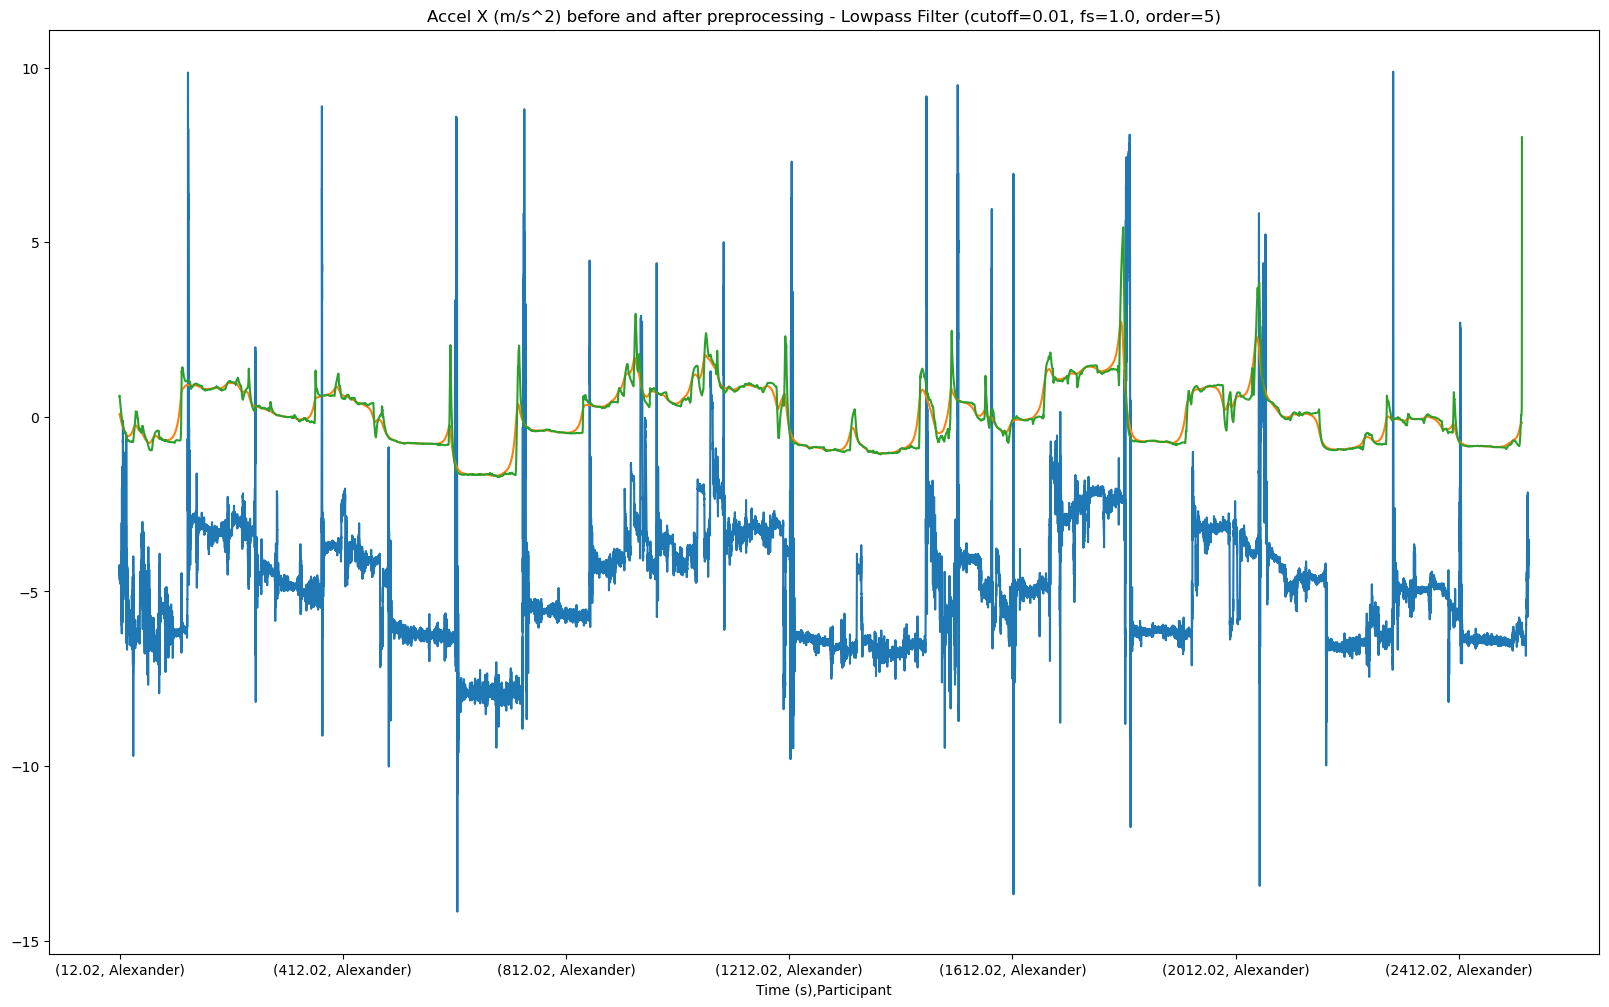

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.interpolate import CubicSpline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from scipy.signal import butter, filtfilt


class DataFrameStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.columns = None

    def fit(self, X, y=None):
        self.scaler.fit(X, y)
        self.columns = X.columns
        return self

    def transform(self, X, y=None):
        transformed_data = self.scaler.transform(X)
        return pd.DataFrame(transformed_data, columns=self.columns, index=X.index)

    
class LowpassFilterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cutoff=0.5, fs=1.0, order=5):
        self.cutoff = cutoff
        self.fs = fs
        self.order = order
    
    def lowpassFilter(self, data):
        nyq = 0.5 * self.fs
        normal_cutoff = self.cutoff / nyq
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_filtered = X.copy()
        for column in X.columns:
            X_filtered[column + '_LP'] = self.lowpassFilter(X[column])
        return X_filtered


class LOFOutlierMarker(BaseEstimator, TransformerMixin):
    def __init__(self, algorithm='kd_tree', n_neighbors=20):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm 
    
    def fit(self, X, y=None):
        self.lof = LocalOutlierFactor(algorithm=self.algorithm, n_neighbors=self.n_neighbors)
        return self
    
    def transform(self, X, y=None):
        X_marked = X.copy()
        outliers = self.lof.fit_predict(X_marked) == -1
        X_marked[outliers] = np.nan
        return X_marked


class CubicSplineInterpolator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_interpolated = X.copy()
 
        nan_idx = X_interpolated.isna().sum(axis=1).astype(bool).values
        times = X_interpolated.index.get_level_values(0)
        for column in X.columns:
            if len(nan_idx) > 0:
                cs = CubicSpline(times[~nan_idx], X_interpolated[column].iloc[~nan_idx])
                X_interpolated.loc[nan_idx, column] = cs(times[nan_idx])
        return X_interpolated


class ExponentialRollingFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, long_span=300, short_span=25):
        self.long_span = long_span
        self.short_span = short_span
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_rolling = X.copy()
        columns_to_transform = X.columns[:9]
        
        for column in columns_to_transform:
            X_rolling[f'{column}_EMA_{self.long_span}'] = X[column].ewm(span=self.long_span).mean()
            X_rolling[f'{column}_EMA_{self.short_span}'] = X[column].ewm(span=self.short_span).mean()
            X_rolling[f'{column}_ESTD_{self.long_span}'] = X[column].ewm(span=self.long_span).std()
            X_rolling[f'{column}_ESTD_{self.short_span}'] = X[column].ewm(span=self.short_span).std()
        
        return X_rolling.iloc[self.long_span*2:, :]


pipeline = Pipeline([
    ('standard_scaler', DataFrameStandardScaler()),
    ('lowpass_filter', LowpassFilterTransformer(cutoff=0.0005, fs=1.0, order=1)),
    ('lof_marker', LOFOutlierMarker(algorithm='kd_tree', n_neighbors=50)),
    ('cubic_spline_interpolator', CubicSplineInterpolator()),
    ('exponential_rolling_features', ExponentialRollingFeatures())
], verbose=True)

# Get Unique Participants 
participants = dfs.index.get_level_values(1).unique()

dfs2 = []
for participant in participants:
    data = dfs.query("Participant == @participant").copy(deep=True)
    data_pre_processed = pipeline.fit_transform(X=data.drop(columns=["Label"]), y=data.Label)
    data_pre_processed['Label'] = data['Label']
    dfs2.append(data_pre_processed)
    # break

dfs2 = pd.concat(dfs2)

# Plot Alexander
data = dfs.query("Participant == 'Alexander'").copy(deep=True)
ax = data['Accel X (m/s^2)'].plot(figsize=(20,12))
dfs2.query("Participant == 'Alexander'")['Accel X (m/s^2)_LP'].plot(ax=ax, title="Accel X (m/s^2) before and after preprocessing - Lowpass Filter (cutoff=0.01, fs=1.0, order=5)")
dfs2.query("Participant == 'Alexander'")['Accel X (m/s^2)_EMA_300'].plot()
# dfs2.isna().sum()


----------------
# **Prediction**

In [14]:
# Importing the necessary libraries for the task
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
_data = dfs.copy(deep=True)         # without pre-processing
_data = dfs2.copy(deep=True)        # with pre-processing
# _data = data_pre_processed.copy(deep=True)

X = _data.drop(columns=['Label'])
y = _data['Label']

# Keeping Alexander's data as test set
alexander_idx = X.index.get_level_values(1) == 'Alexander'

X_train, X_test, y_train, y_test = X[~alexander_idx], X[alexander_idx], y[~alexander_idx], y[alexander_idx]

# Initialize AutoML
automl = AutoML()

# Define the settings for FLAML
settings = {
    "time_budget": 1*60,  # time budget in seconds
    "metric": 'accuracy',  # primary metric to optimize
    "task": 'classification',  # type of task
    "log_file_name": 'flaml.log',  # flaml log file
    "estimator_list": ['lgbm'],  # list of estimators
    "eval_method": 'cv',  # cross-validation method
    "n_splits": 5,  # number of folds for cross-validation

    # skip preprocessing
    "skip_transform": False
}

# Train the model
automl.fit(X_train, y_train, **settings)

# Get predictions
y_pred = automl.predict(X_test)

In [120]:
import numpy as np
import pandas as pd
from sklearn.model_selection import BaseCrossValidator
from flaml import AutoML
from sklearn.metrics import classification_report

class UniqueIdLeaveOneOutCV(BaseCrossValidator):
    def __init__(self, validation_column, n_splits=2):
        self.validation_column = validation_column
        self.n_splits = n_splits

    def split(self, X):
        _X = X.copy(deep=True).reset_index()
        unique_ids = np.unique(_X[self.validation_column])

        its = 0
        for val_id in unique_ids:
            if its == self.n_splits: break
            train_index = _X.index.values[(_X[self.validation_column] != val_id)]
            test_index  = _X.index.values[(_X[self.validation_column] == val_id)]

            yield train_index, test_index
            its += 1

    def get_n_splits(self):
        return self.n_splits

# Assuming dfs and dfs2 are defined elsewhere
_data = dfs.copy(deep=True)  # without pre-processing
_data = dfs2.copy(deep=True)  # with pre-processing

X = _data.drop(columns=['Label'])
y = _data['Label']

# Keeping Alexander's data as test set
alexander_idx = X.index.get_level_values(1) == 'Alexander'

# Splitting data for training and test sets
X_train, X_test, y_train, y_test = X[~alexander_idx], X[alexander_idx], y[~alexander_idx], y[alexander_idx]


# Initialize AutoML
automl = AutoML()

# Define the settings for FLAML
settings = {
    "time_budget": 20 * 60,  # time budget in seconds
    "metric": 'accuracy',  # primary metric to optimize
    "task": 'classification',  # type of task
    # "estimator_list": ['lgbm'],
    "log_file_name": 'flaml_logs.log',  # flaml log file
    'log_type': 'all',
    "seed": 7654321,  # random seed
    'eval_method': 'cv',
    'split_type': UniqueIdLeaveOneOutCV(validation_column='Participant'),  # Use the custom CV here
    'skip_transform': False, # !! Keep False

    'retrain_full':True, # Re trains the estimator with the full data
}

# Train the model with validation data
automl.fit(X_train, y_train, **settings)

# Get predictions
y_pred_test = automl.predict(X_test)

[flaml.automl.logger: 06-14 16:03:19] {1680} INFO - task = classification
[flaml.automl.logger: 06-14 16:03:19] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-14 16:03:19] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 06-14 16:03:19] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 06-14 16:03:19] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-14 16:03:21] {2345} INFO - Estimated sufficient time budget=12993s. Estimated necessary time budget=299s.
[flaml.automl.logger: 06-14 16:03:21] {2392} INFO -  at 3.6s,	estimator lgbm's best error=0.6308,	best estimator lgbm's best error=0.6308
[flaml.automl.logger: 06-14 16:03:21] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-14 16:03:22] {2392} INFO -  at 4.7s,	estimator lgbm's best error=0.6308,	best estimator lgbm's best error=0.6308
[flaml.automl.logger: 06-14 16:0

KeyboardInterrupt: 

In [121]:
# Get the best model for each estimator
estimator_performance = {}
for estimator_name in automl.best_config_per_estimator.keys():
    estimator = automl.best_model_for_estimator(estimator_name)
    estimator_performance[estimator_name] = {
        'best_config': automl.best_config_per_estimator[estimator_name],
        'best_loss': automl.best_loss_per_estimator[estimator_name],
        'best_iteration': automl.best_iteration,
    }

# Create a DataFrame to store the performance report
estimator_performance_df = pd.DataFrame(estimator_performance).T

estimator_performance_df

best_config best_loss  \
lgbm            {'n_estimators': 7, 'num_leaves': 4, 'min_chil...  0.629342   
rf              {'n_estimators': 4, 'max_leaves': 13, 'max_fea...  0.594409   
xgboost         {'n_estimators': 561, 'max_leaves': 4, 'min_ch...  0.636079   
extra_tree      {'n_estimators': 4, 'max_leaves': 18, 'max_fea...   0.60097   
xgb_limitdepth  {'n_estimators': 125, 'max_depth': 2, 'min_chi...  0.643399   
lrl1                                    {'C': 3.9999999999999987}  0.705204   

               best_iteration  
lgbm                      300  
rf                        300  
xgboost                   300  
extra_tree                300  
xgb_limitdepth            300  
lrl1                      300

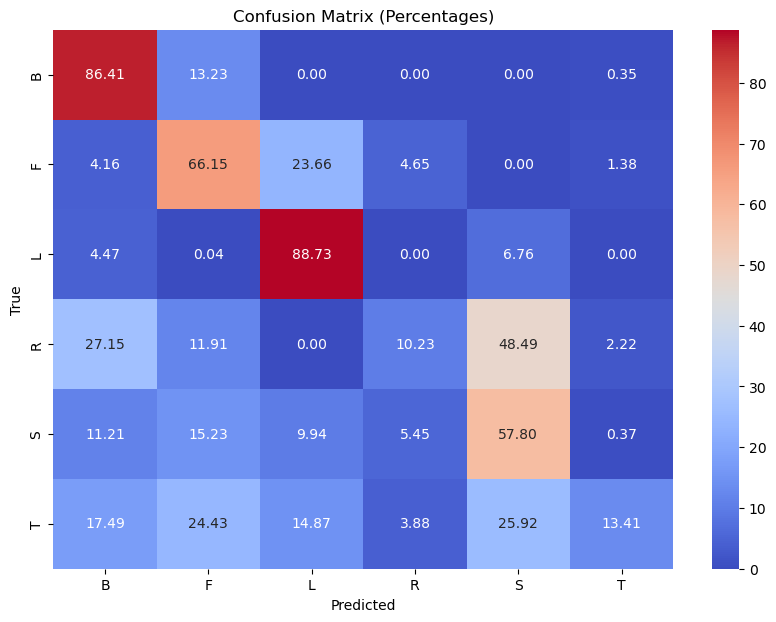

precision    recall  f1-score        support
B              0.606411  0.864136  0.712690   22000.000000
F              0.562135  0.661455  0.607764   22000.000000
L              0.734287  0.887338  0.803590   27649.000000
R              0.462677  0.102273  0.167517   22000.000000
S              0.456671  0.578000  0.510222   22000.000000
T              0.585079  0.134100  0.218191   10000.000000
accuracy       0.592158  0.592158  0.592158       0.592158
macro avg      0.567877  0.537884  0.503329  125649.000000
weighted avg   0.573716  0.592158  0.544060  125649.000000

In [128]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y_test and y_pred_test are defined
# Create a classification report
report = classification_report(y_test, y_pred_test, output_dict=True)
report_df = pd.DataFrame(report).T

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=report_df.index[:-3], yticklabels=report_df.index[:-3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()

# Print Classification Report
report_df


---------------------------
# Feature Importance from Random Forests

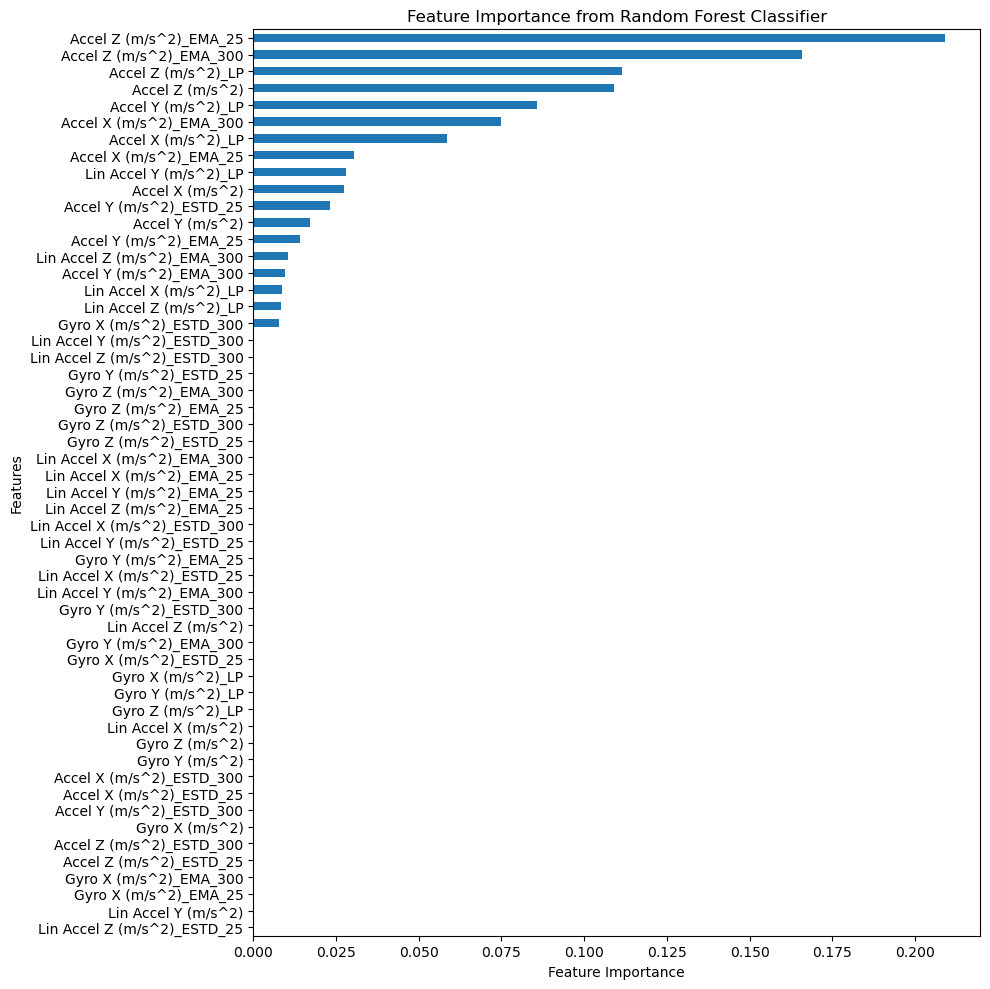

In [122]:
from sklearn.ensemble import RandomForestClassifier

# get RF best config from the 
best_rf_config = estimator_performance_df.loc['rf', 'best_config'].copy()
best_rf_config['max_leaf_nodes'] = best_rf_config['max_leaves']

# remove from the dict the element which name is 'max_leaves'

best_rf_config.pop('max_leaves')
# # Assuming X_train and y_train are already defined
model = RandomForestClassifier(n_jobs=-1, **best_rf_config).fit(X_train, y_train)
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 10))
feature_importance.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()
